In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
import os
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [9]:
data = pd.read_csv('train.csv')
print(f'The number of datapoints is {data.shape}')
data.head(5)

The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [12]:
data = data.dropna()
data.shape

(404287, 6)

In [13]:
data[data.drop(columns=['id']).duplicated()]

,id,qid1,qid2,question1,question2,is_duplicate


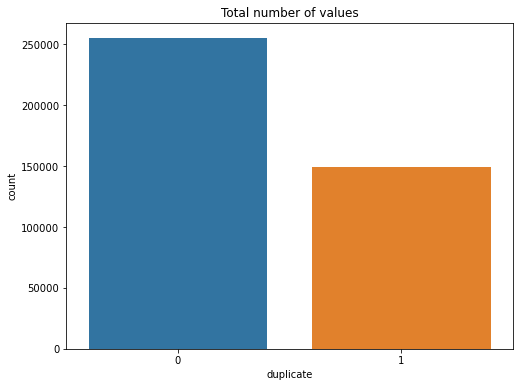

Total number of question pairs is 404287
Question pairs that are similar is 149263 which is 37 % of total
Question pairs that are not similar is 255024 which is 63 % of total


In [14]:
plt.figure(figsize=(8,6))
ct = data['is_duplicate'].value_counts()
sns.barplot(x=ct.index,y=ct.values)
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.show()

print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Question pairs that are similar is {} which is {} % of total'.format(ct[1],round((ct[1]/(ct[1]+ct[0])*100)),2))
print('Question pairs that are not similar is {} which is {} % of total'.format(ct[0],round((ct[0]/(ct[1]+ct[0])*100)),2))

In [15]:
qids = pd.Series(data.qid2.tolist() + data.qid1.tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 537929
Number of questions that repeated more than 1 time is 111778 which is 20.779322178205675%
The maximum number of times a question occured is 157


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


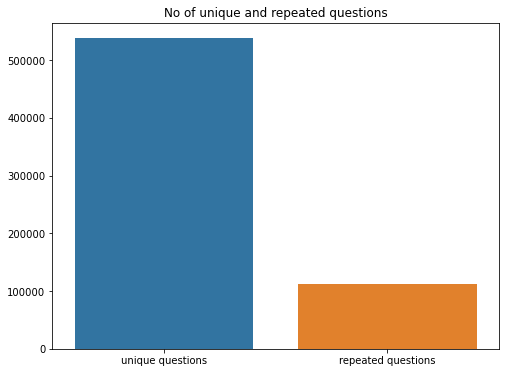

In [16]:
plt.figure(figsize=(8,6))
x = ['unique questions','repeated questions']
y = [uniq,more1]
sns.barplot(x,y)
plt.title('No of unique and repeated questions')
plt.show()

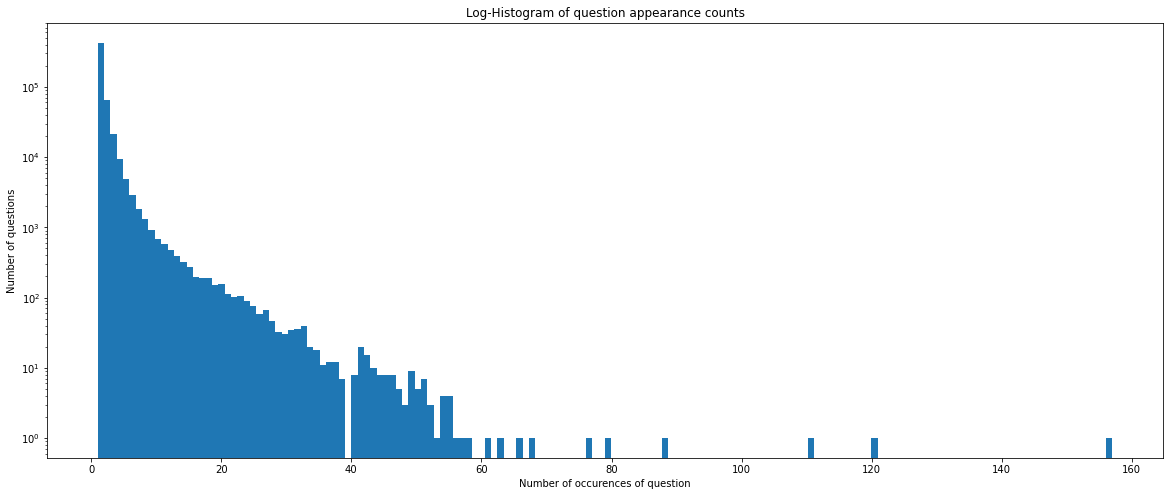

In [17]:
plt.figure(figsize=(20, 8))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

In [18]:
if os.path.isfile('data_with_out_preprocess.csv'):
    data = pd.read_csv("data_with_out_preprocess.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y)


    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))

    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x


In [19]:
data['freq_qid1'] = data['qid1'].apply(lambda x: cnt[x])
data['freq_qid2'] = data['qid2'].apply(lambda x: cnt[x])
data['q1len'] = data['question1'].apply(lambda x: len(x))
data['q2len'] = data['question2'].apply(lambda x: len(x))
data['q1_n_words'] = data['question1'].apply(lambda x: len(x.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda x: len(x.split(" ")))
data['word_common'] = data.apply(common_wrd,axis=1)
data['word_total'] = data.apply(total,axis=1)
data['word_share'] = data.apply(word_share,axis=1)
data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])
data.to_csv("data_with_out_preprocess.csv", index=False)

In [20]:
data = pd.read_csv('data_with_out_preprocess.csv')
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


In [21]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


In [22]:
data[data['q1_n_words']== 1].head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
3306,3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,1,1,56,1,10,0.0,10.0,0.0,2,0
13016,13016,25026,25027,?,Why should one not work at Google?,0,2,2,1,34,1,7,0.0,8.0,0.0,4,0
17682,17682,33561,33562,deleted,Which website will be suitable for downloading...,0,7,1,7,67,1,10,0.0,11.0,0.0,8,6


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


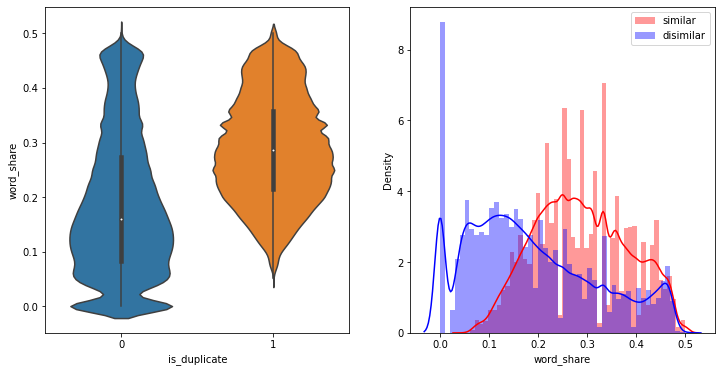

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1]['word_share'],color='red',label='similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_share'],color='blue',label='disimilar')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


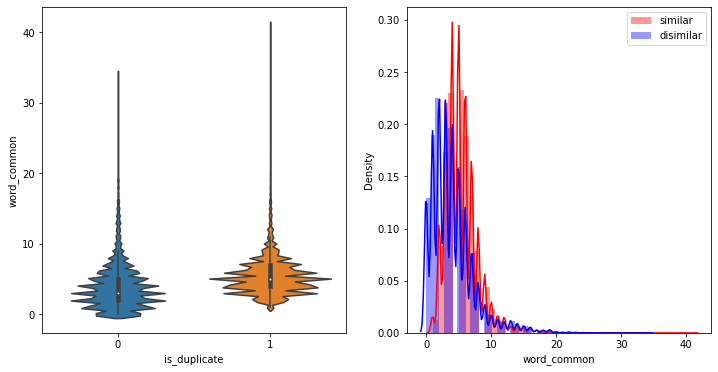

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


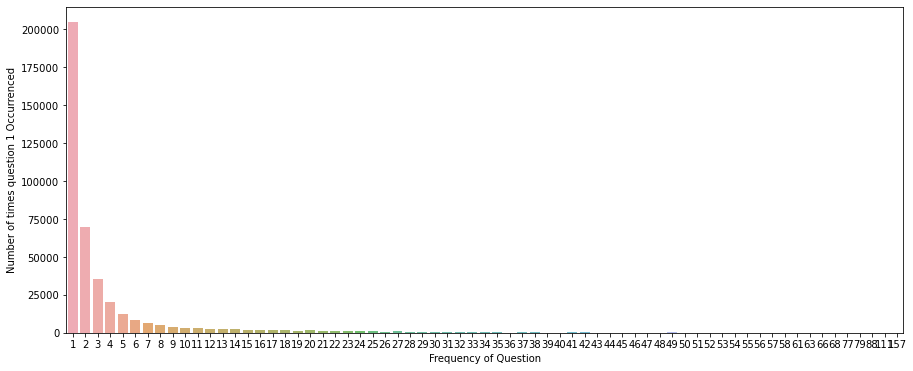

In [25]:
# Frequency of Question 1
plt.figure(figsize=(15,6))
my_count = data['freq_qid1'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 1 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


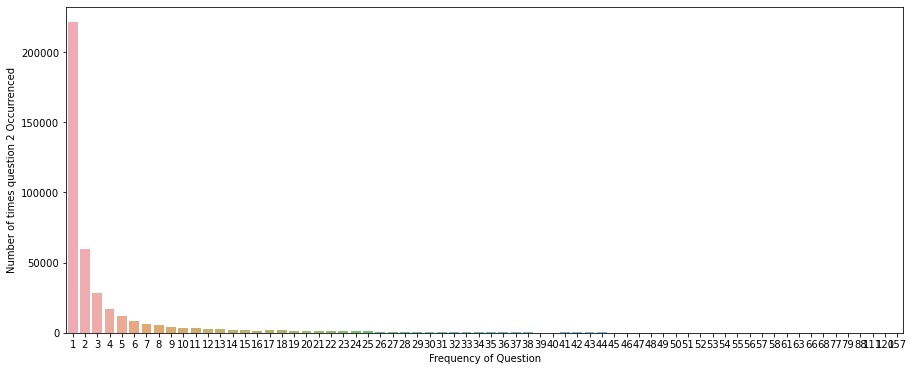

In [26]:
# Frequency of Question 2
plt.figure(figsize=(15,6))
my_count = data['freq_qid2'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 2 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    
    porter = PorterStemmer()    #apply stemming  eg: growing,growth --> grow
    pattern = re.compile('\W')  #matching word charecter
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [29]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
       
    SAFE_DIV = 0.0001 
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))      # will return longest common substring 
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # To get the results in 4 decemal points
    
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

     #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [30]:
df = extract_features(data)
df.to_csv("data_with_preprocess_2.csv", index=False)

token features...
fuzzy features..


In [31]:
df = pd.read_csv("data_with_preprocess_2.csv")
print(df.shape)
df.head(2)

(404287, 32)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,2,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [32]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

In [33]:
sent_dup =np.dstack([df_duplicate['question1'].values,df_duplicate['question2'].values])
#words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
######
sent_ndup =np.dstack((df_nonduplicate['question1'].values,df_nonduplicate['question2'].values))
#words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

In [34]:
textp_w = words_dup
#open(path.join(d, 'train_p.txt')).read()
textn_w = words_ndup
#open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


textn_w = [str(i) for i in textn_w]
textp_w = [str(i) for i in textp_w]
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510048


Word Cloud for Duplicate Question pairs


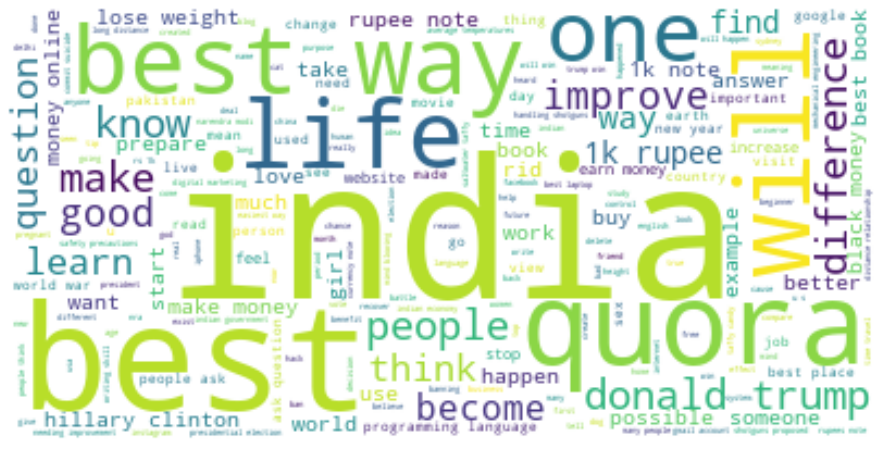

In [35]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


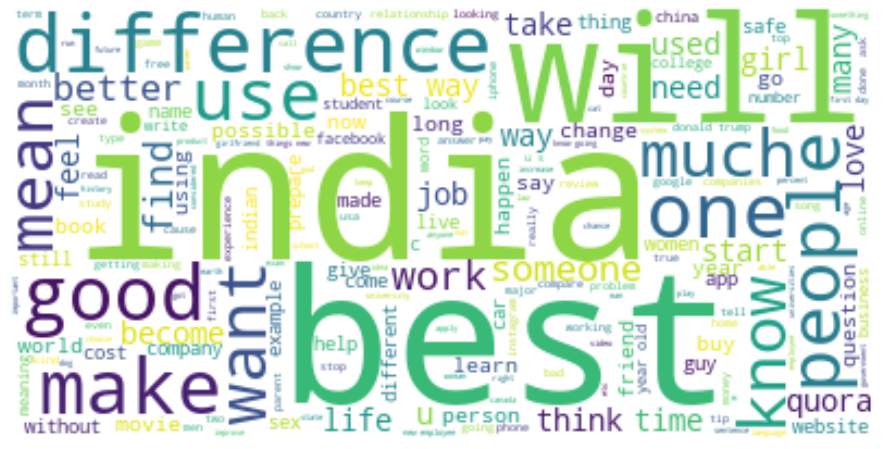

In [36]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

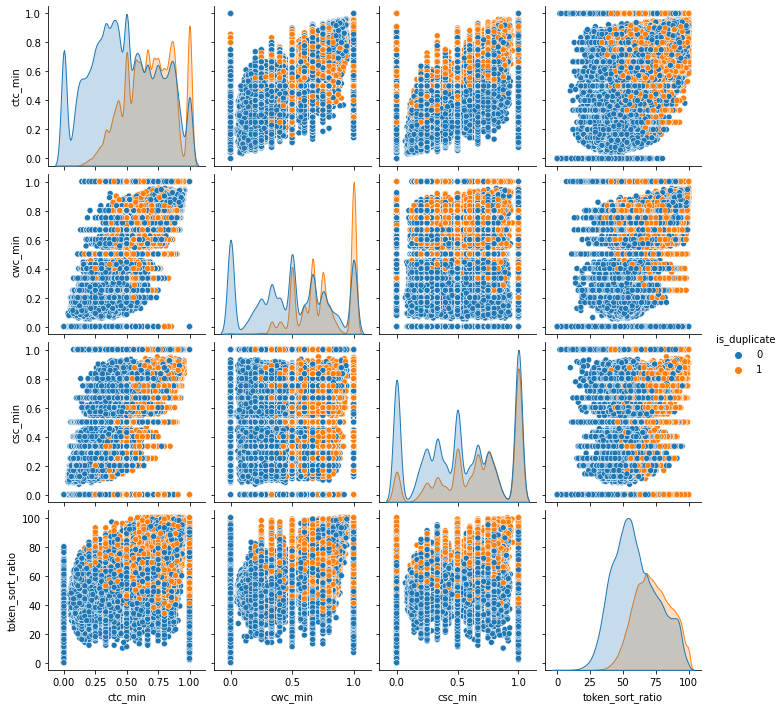

<Figure size 1152x576 with 0 Axes>

In [37]:
sns.pairplot(df, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.figure(figsize=(16,8))
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


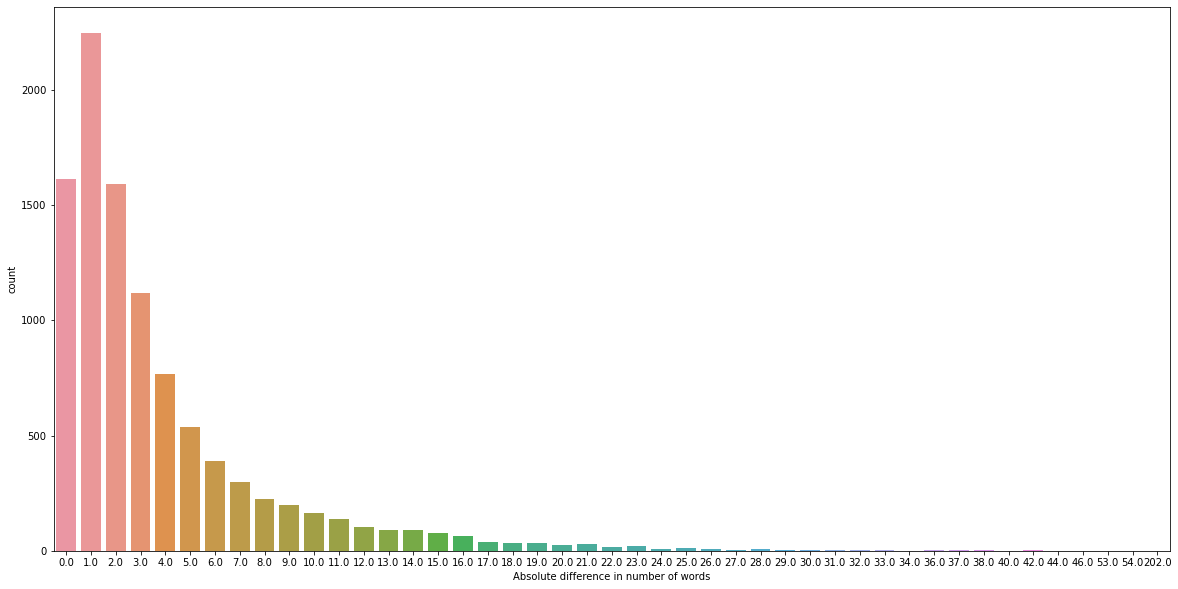

In [38]:
plt.figure(figsize=(20, 10))
dist = df['abs_len_diff'][0:10000].values
dist.min()
plt.xlabel('Absolute difference in number of words')
sns.countplot(dist)
plt.show()

In [39]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 0.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.156s
[t-SNE] Iteration 50: error = 80.9855804, gradient norm = 0.0432390 (50 iterations in 2.524s)
[t-SNE] Iteration 100: error = 70.4473877, gradient norm = 0.0093234 (50 iterations in 1.377s)
[t-SNE] Iteration 150: error = 68.6607971, gradient norm = 0.0054945 (50 iterations in 0.929s)
[t-SNE] Iteration 200: error = 67.8072128, gradient norm = 0.0052081 (50 iterations in 1.118s)
[t-SNE] Iteration 250: error = 67.3104553, gradient norm = 0.0034786

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


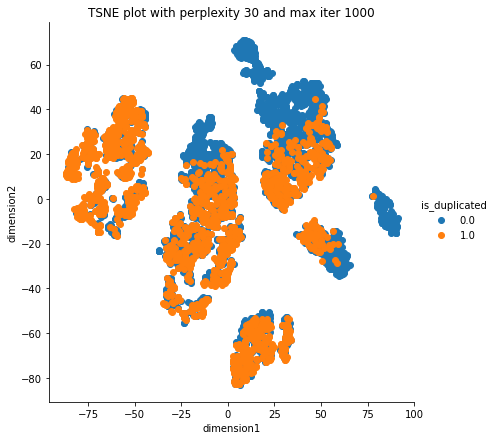

In [40]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)
#tsne result will appear as 2 columns.We have to plot it
# creating a new data frame which help us in ploting the tsne_result
tsne_new = np.vstack((tsne2d.T,dfp_subsampled['is_duplicate'])).T
df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2",
"is_duplicated"))
# Ploting the result
sns.FacetGrid(df, hue="is_duplicated", size=6).map(plt.scatter, 'dimension1',
'dimension2').add_legend()
plt.title("TSNE plot with perplexity 30 and max iter 1000")
plt.show()